In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import QuantTrading.BackTest as BT
import matplotlib.pyplot as plt
import QuantTrading.SyntheticAlpha as SA
plt.style.use("ggplot")
%config InlineBackend.figure_format='retina'

def load_from_pickle(filename):
    path = '../pkl_dump/' # it mean the folder is in the same directory as the notebook
    with open(path + filename, 'rb') as f:
        return pickle.load(f)

# load model parameters
def load_from_impact_pickle(filename):
    path = 'impact_model_summary/' # it mean the folder is in the same directory as the notebook
    with open(path + filename, 'rb') as f:
        return pickle.load(f)

# Load data
traded_volume_df = load_from_pickle('traded_volume_df.pkl')
px_df = load_from_pickle('px_df.pkl') # price dataframe
daily_stock_info_df = load_from_pickle('daily_stock_info_df.pkl')
monthly_scaling_factor = load_from_pickle('monthly_scaling_factor.pkl')
stocks = traded_volume_df.reset_index()["stock"].unique()

# load model fitting results
ow_summary = load_from_impact_pickle('ow_summary.pkl')
afs_summary = load_from_impact_pickle('afs_summary.pkl')


### helper function

In [2]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    """
    obtain the impact state I_t by ewma method, need to choose model type
    linear: OW model; sqrt: 
    """
    # space kernels
    space_kernels = {
        "linear": lambda x: x,
        "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    time_unit = 10  # 10 seconds
    decay_factor = np.exp(-beta * time_unit)
    pre_ewm = traded_volume_df
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    

    
    #pre_ewm = pre_ewm.divide(monthly_scaling_factor["ave daily volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    #pre_ewm = pre_ewm.multiply(monthly_scaling_factor["price volatility"], axis="rows")

    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns
    return cum_impact

def impact_adjusted_prices(pre_ewm, px_df, scaling_df, half_life, impact_coef_df, model_type):
    """
    P(t) -> S(t)
    calculate the adjusted prices after removing the impact
    inputs:
    pre_ewm: impact state
    px_df: price dataframe
    scaling_df: scaling factor dataframe, where scaling factor is the average daily volume
    half_life: half life of the impact, typically 3600
    impact_coef_df: impact coefficient dataframe where we need beta_estimate
    model_type: linear or sqrt
    """
    cum_impacts = impact_state(pre_ewm, scaling_df, half_life, model_type).T # cumulative impact
    cum_returns = px_df.T / px_df.T.iloc[0, :] - 1 # cumulative returns
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    # stock_date_df["month"] = pd.to_datetime(stock_date_df["date"]).dt.month
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    # merge the impact coefficients
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns -= cum_impacts * impact_coefficients # adjusted returns by removing impact
    adjusted_px_df = (px_df.T.iloc[0, :] * (cum_returns + 1)).T.reset_index() # get price from returns
    return adjusted_px_df

def strategy_adjusted_prices(pre_ewm, adjusted_px_df, scaling_df, decay_factor, impact_coef_df, kernel):
    """
    S(t) -> P(t) by adding the impact of the strategy
    adjusts the prices based on the impacts of a trading strategy, considering decay factors, scaling, and kernel effects
    inputs:
        pre_ewm: trade volume dataframe
        adjusted_px_df: fundamental price dataframe S(t)
        scaling_df: scaling factor dataframe, contain px_vol and volume
        decay_factor: decay factor, or beta
        impact_coef_df: impact coefficient dataframe
        kernel: kernel function
    """
    pre_ewm_copy = pre_ewm.copy()
    pre_ewm_copy = kernel(pre_ewm_copy)
    pre_ewm_copy.iloc[:, 1:] /= (1 - decay_factor)
    cum_impacts = pre_ewm_copy.ewm(alpha=1-decay_factor, adjust=False).mean()
    scaler_df = pd.merge(cum_impacts.T.iloc[:, 0], scaling_df, on=["stock", "date"])
    cum_impacts *= (scaler_df["px_vol"] / kernel(scaler_df["volume"])).values
    cum_returns = adjusted_px_df.T / adjusted_px_df.T.iloc[:, 0] - 1
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns += cum_impacts * impact_coefficients
    strategy_adjusted_px_df = (adjusted_px_df.T.iloc[:, 0] * (cum_returns + 1)).T.reset_index()
    return strategy_adjusted_px_df

def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    """
    S(t)-> P(t), more general it only need the trades and prices
    adjusts prices based on the impacts of a trading strategy, taking into account the decay factor, scaling, and kernel effects.
    inputs:
        trades: trade dataframe
        prices: price dataframe S(t)
        decay: decay factor, or beta
        impact_coef: impact coefficient, lambda
        kernel: kernel function
        price_vol: price volatility
        ADV: average daily volume
    """
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    if len(np.shape(trades_copy)) == 1:
        trades_copy[1:] /= (1 - decay)
    else:
        trades_copy.iloc[:, 1:] /= (1 - decay) # divide by decay factor
    # calculate the impact of such trade strategy by the beta from the impact coefficient
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean() # I(t) = (1 - decay) * I(t-1) + decay * I(t)
    cum_impacts *= price_vol / kernel(ADV) # multiply by price volatility and divide by kernel of ADV
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

# kernel
def sqrt_kernel(values):
    return np.sqrt(np.abs(values)) * np.sign(values)

def linear_kernel(values):
    return values


In [3]:
# specify parameters
stock = "AAPL"
date = "2019-05-02"
half_life = 3600
corr = 0.6 # correlation between alpha and return
corrs = [0.1, 0.6, 0.9]  # correlation between alpha and return
model_types = ["linear", "sqrt"]  # model types
alpha_horizons = [6, 12, 30]  # look ahead horizon
alpha_horizon = 6 # look ahead horizon, 6 = 1 min
time_unit = 10  # 10 seconds
half_life = 3600
beta = np.log(2) / half_life # determine beta through required half life
decay_factor = np.exp(-beta * time_unit)
px_vol, ADV = monthly_scaling_factor.loc[stock, date]
model_type = "linear" # specify model type for optimal trade



# obtain alpha and optimal trades
# first 200 alphas for ewma

alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon,smooth=True).loc[date][200:]
optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary,stock,date,model_type)
pct_synthetic_alpha_optimal_trades = optimal_trades/ADV


In [4]:
# obtain S(t) with OW model
px_df2 = impact_adjusted_prices(traded_volume_df.copy(), px_df, monthly_scaling_factor, half_life, ow_summary, "linear")
prices = px_df2.loc[(px_df2["stock"] == stock) & (px_df2["date"] == date)].iloc[:, 202:] # given stock and date, transpose
#prices.columns = ["Impact Adjusted Price"] # S_t for given 

# obtain the impact I_t for a given alpha series
alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]
intended_impacts = 1/2 * (alphas_series - alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
intended_impacts.iloc[-1] = alphas_series.iloc[-1] # I_T^* = \alpha_T
"""
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
px_df.loc[stock, date][200:].plot(ax=ax, label="Original Price", lw=1)
prices.plot(ax=ax, label="Impact Adjusted Price", lw=1)
plt.title("Original Price vs Impact Adjusted Price")
plt.legend()
"""
prices

time,10:03:20,10:03:30,10:03:40,10:03:50,10:04:00,10:04:10,10:04:20,10:04:30,10:04:40,10:04:50,...,15:58:30,15:58:40,15:58:50,15:59:00,15:59:10,15:59:20,15:59:30,15:59:40,15:59:50,16:00:00
833,211.881337,211.863634,211.862709,211.878978,211.835961,211.877427,211.892652,211.873499,211.846325,211.954432,...,209.021821,209.07149,209.114443,209.131021,209.337054,209.408608,209.345175,209.288979,209.629442,209.628684


In [5]:
# trade & pnl
def backtest(trades, intended_impacts, prices):
    """
    trades: array of trades
    intended_impacts: intended impacts for the trades
    prices: price dataframe
    """
    Qs = trades.cumsum()  # trade position is cumsum of trade
    # Integral Q_tdS_t
    fundamental_gain = (prices.T.pct_change(1).T * Qs.shift(-1)).T
    # integral I_t dQ_t
    impact_cost = -intended_impacts * trades.shift(-1)
    pnls = (fundamental_gain.unstack() + impact_cost).fillna(0).cumsum().T
    return pnls

def pnl_metrics(pnls):
    """
    calculate the pnl metrics
    """
    # calculate the sharpe ratio
    sharpe = pnls.mean() / pnls.std() * np.sqrt(252)  # scale by 252 since it is annualized sharpe
    # calculate the max drawdown as in pct
    max_drawdown = (pnls.cumsum() - pnls.cumsum().cummax()).min()

    return sharpe, max_drawdown


(6.942516384184812, -2763625.2517462904)


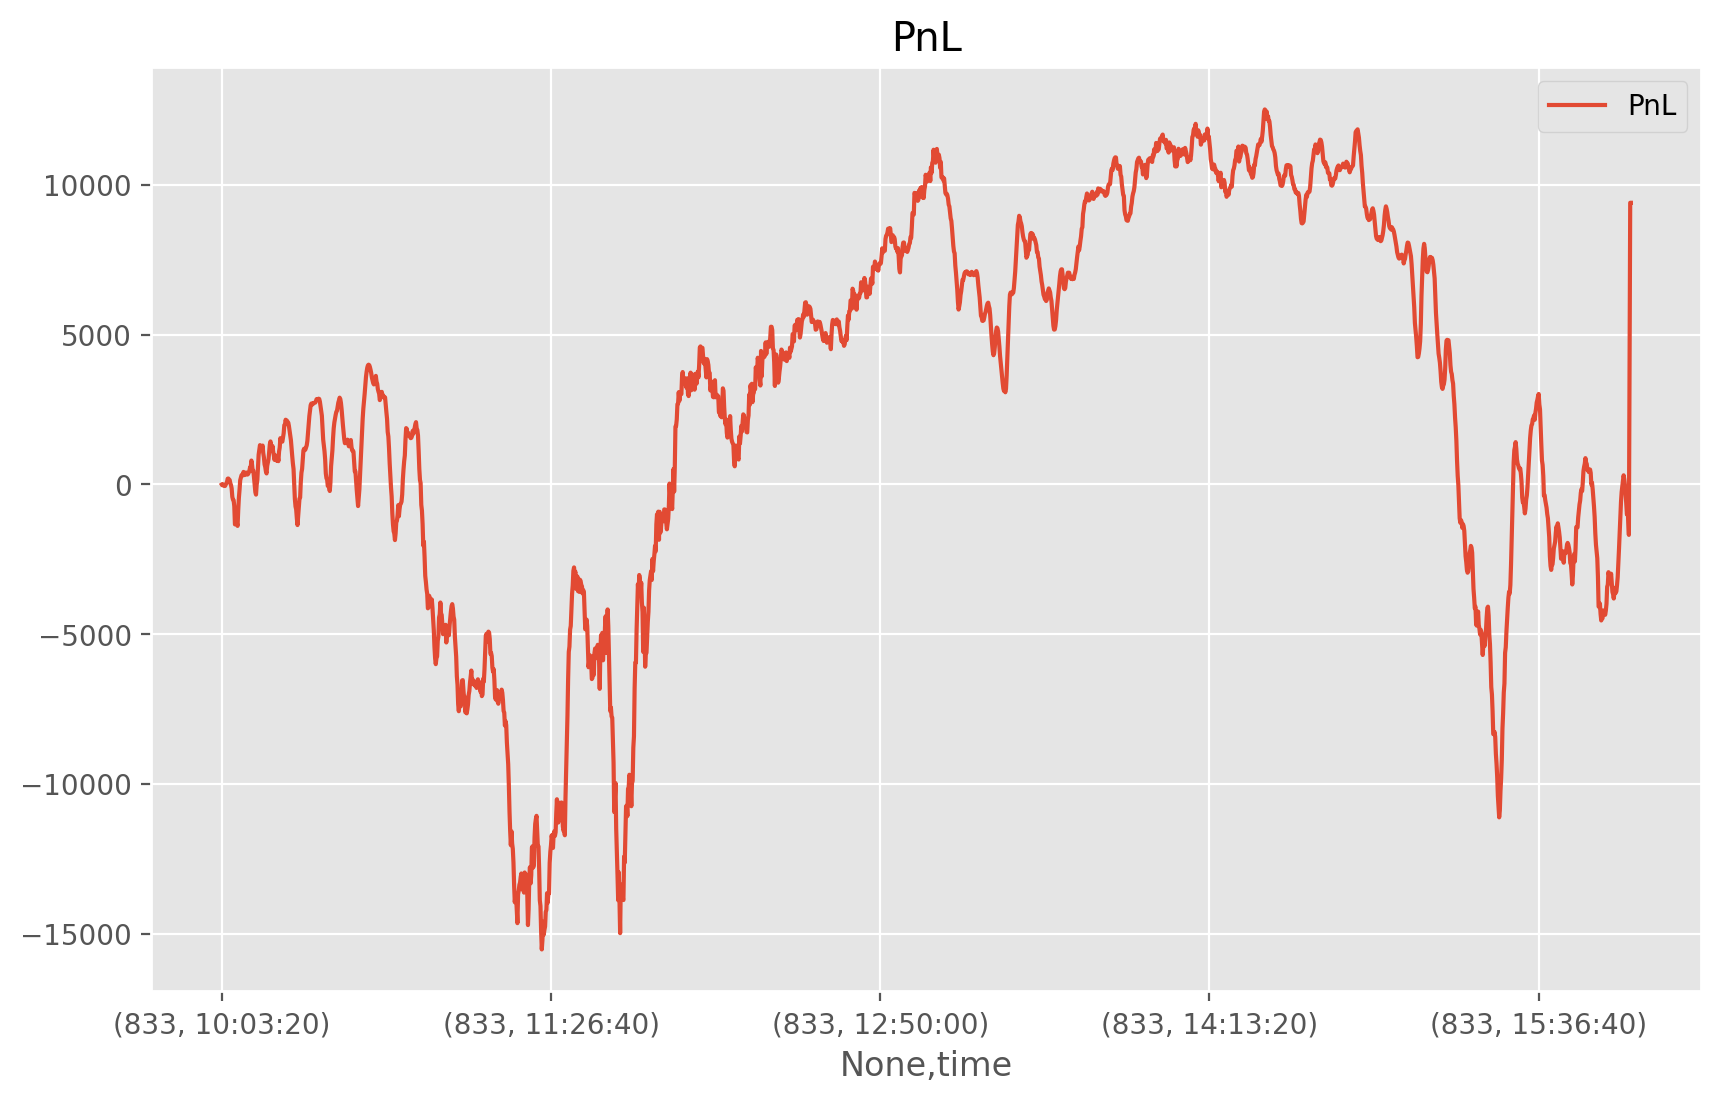

In [6]:
pnls = backtest(optimal_trades, intended_impacts, prices)
print(pnl_metrics(pnls))
# plot the pnls
fig, ax = plt.subplots(figsize=(10, 6))
pnls.plot(ax=ax, label="PnL")
plt.title("PnL")
plt.legend()
plt.show()

### Impact of Correlation (across model)

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/603312656.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV")
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/603312656.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV")
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/603312656.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure pa

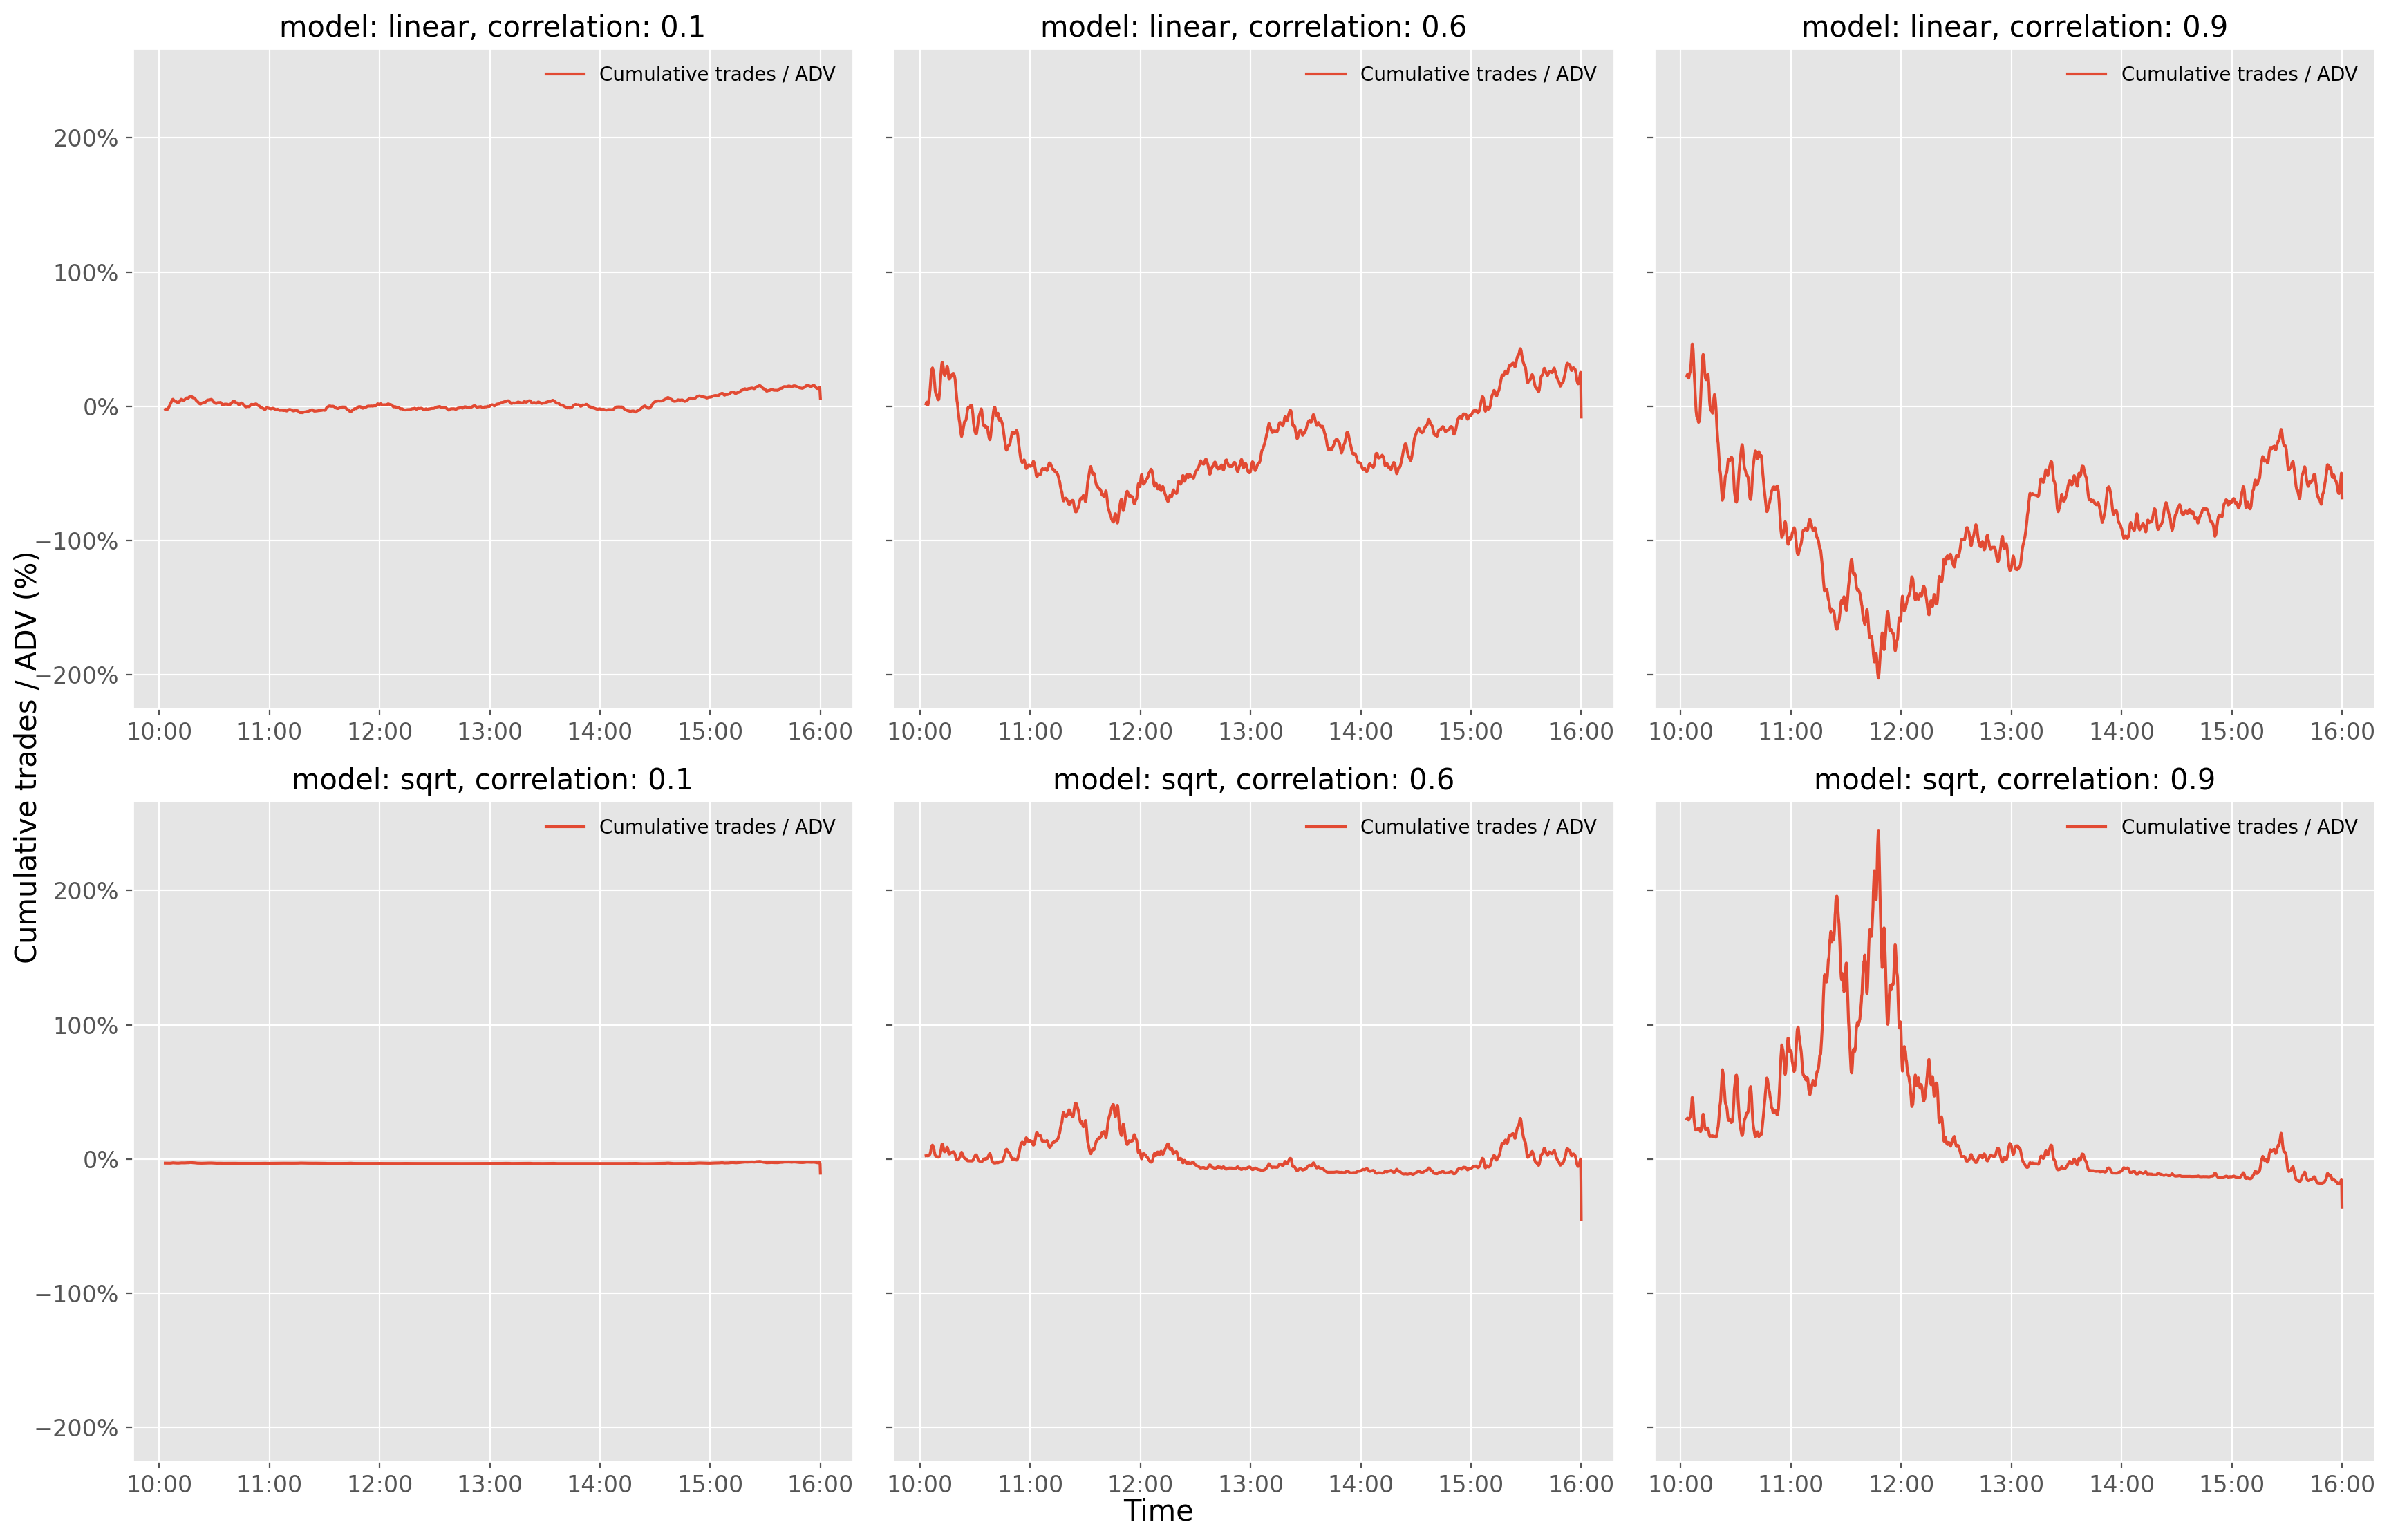

In [7]:
# Plotting

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for j, model_type in enumerate(model_types):
    for i, corr in enumerate(corrs):
        # Generate synthetic alpha series
        alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

        # Calculate optimal trades
        optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, model_type)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV
        
        
        # Plot the results
        ax = axes[j, i]
        ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV")
        ax.set_title(f"model: {model_type}, correlation: {corr}", fontsize=15)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        xfmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(xfmt)
        ax.legend(fontsize=10, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=12)

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Cumulative trades / ADV (%)', va='center', rotation='vertical', fontsize=15)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

Model: linear, Correlation: 0.1, Annualized Sharpe: 15.501044389243782, Max Drawdown: -66871.94424764499


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: linear, Correlation: 0.6, Annualized Sharpe: 14.922091987571541, Max Drawdown: -2172943.6911154455


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: linear, Correlation: 0.9, Annualized Sharpe: -1.9709283745423811, Max Drawdown: -24704360.880920082


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.1, Annualized Sharpe: 32.906830957146454, Max Drawdown: -1141.9951708907972


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.6, Annualized Sharpe: -12.990803383401728, Max Drawdown: -25720167.057523496


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.9, Annualized Sharpe: -12.320611928313474, Max Drawdown: -192724428.14481023


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1183417184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


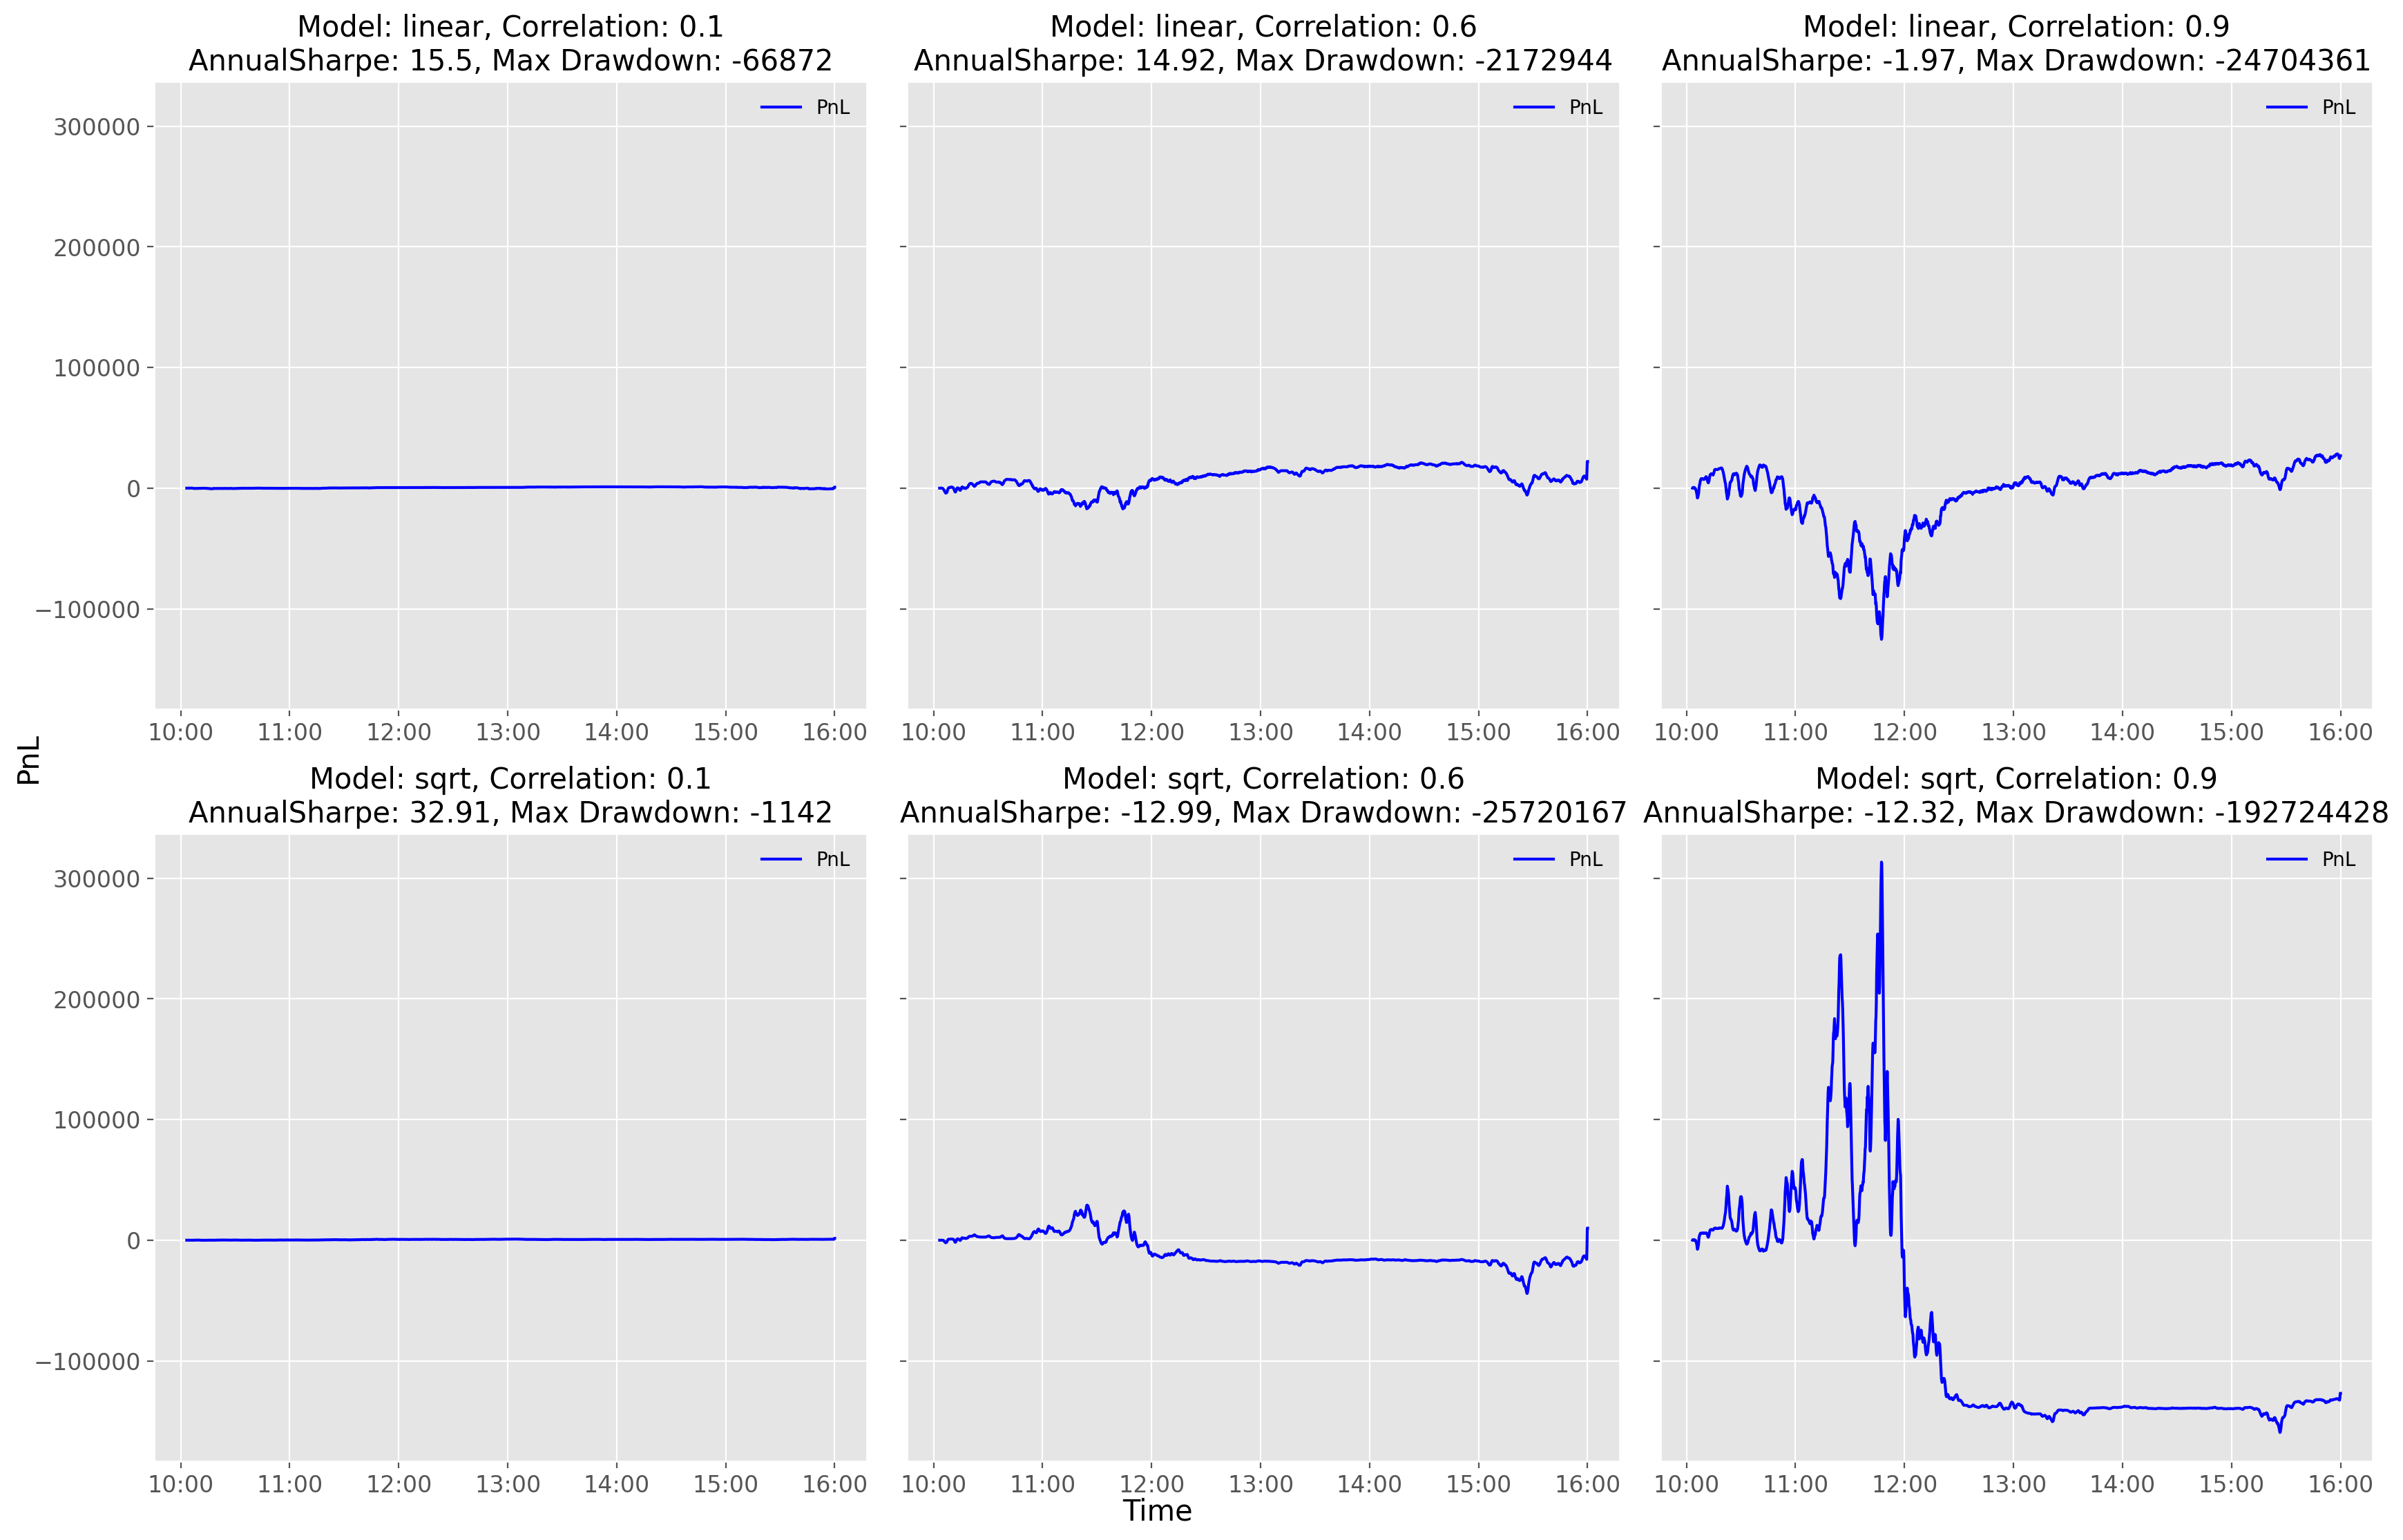

In [8]:
# Plotting of pnls
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for j, model_type in enumerate(model_types):
    for i, corr in enumerate(corrs):
        # Generate synthetic alpha series
        alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

        # Calculate optimal trades
        optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, model_type)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV
        
        # Calculate pnl and corresponding metrics
        intended_impacts = BT.get_intended_impact(alphas_series, ow_summary, stock, model_type)
        pnls = backtest(optimal_trades, intended_impacts, prices)
        sharpe, max_drawdown = pnl_metrics(pnls)
        print(f"Model: {model_type}, Correlation: {corr}, Annualized Sharpe: {sharpe}, Max Drawdown: {max_drawdown}")
        
        # Plot the results
        ax = axes[j, i]
        ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')
        ax.set_title(f"Model: {model_type}, Correlation: {corr}\nAnnualSharpe: {round(sharpe, 2)}, Max Drawdown: {round(max_drawdown)}", fontsize=15)
        xfmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(xfmt)
        ax.legend(fontsize=10, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=12)

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'PnL', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1774623322.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), alphas_series.values, label="Synthetic alpha", color='blue')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1774623322.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), intended_impacts.values, label="Impacts", color='red')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1774623322.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify

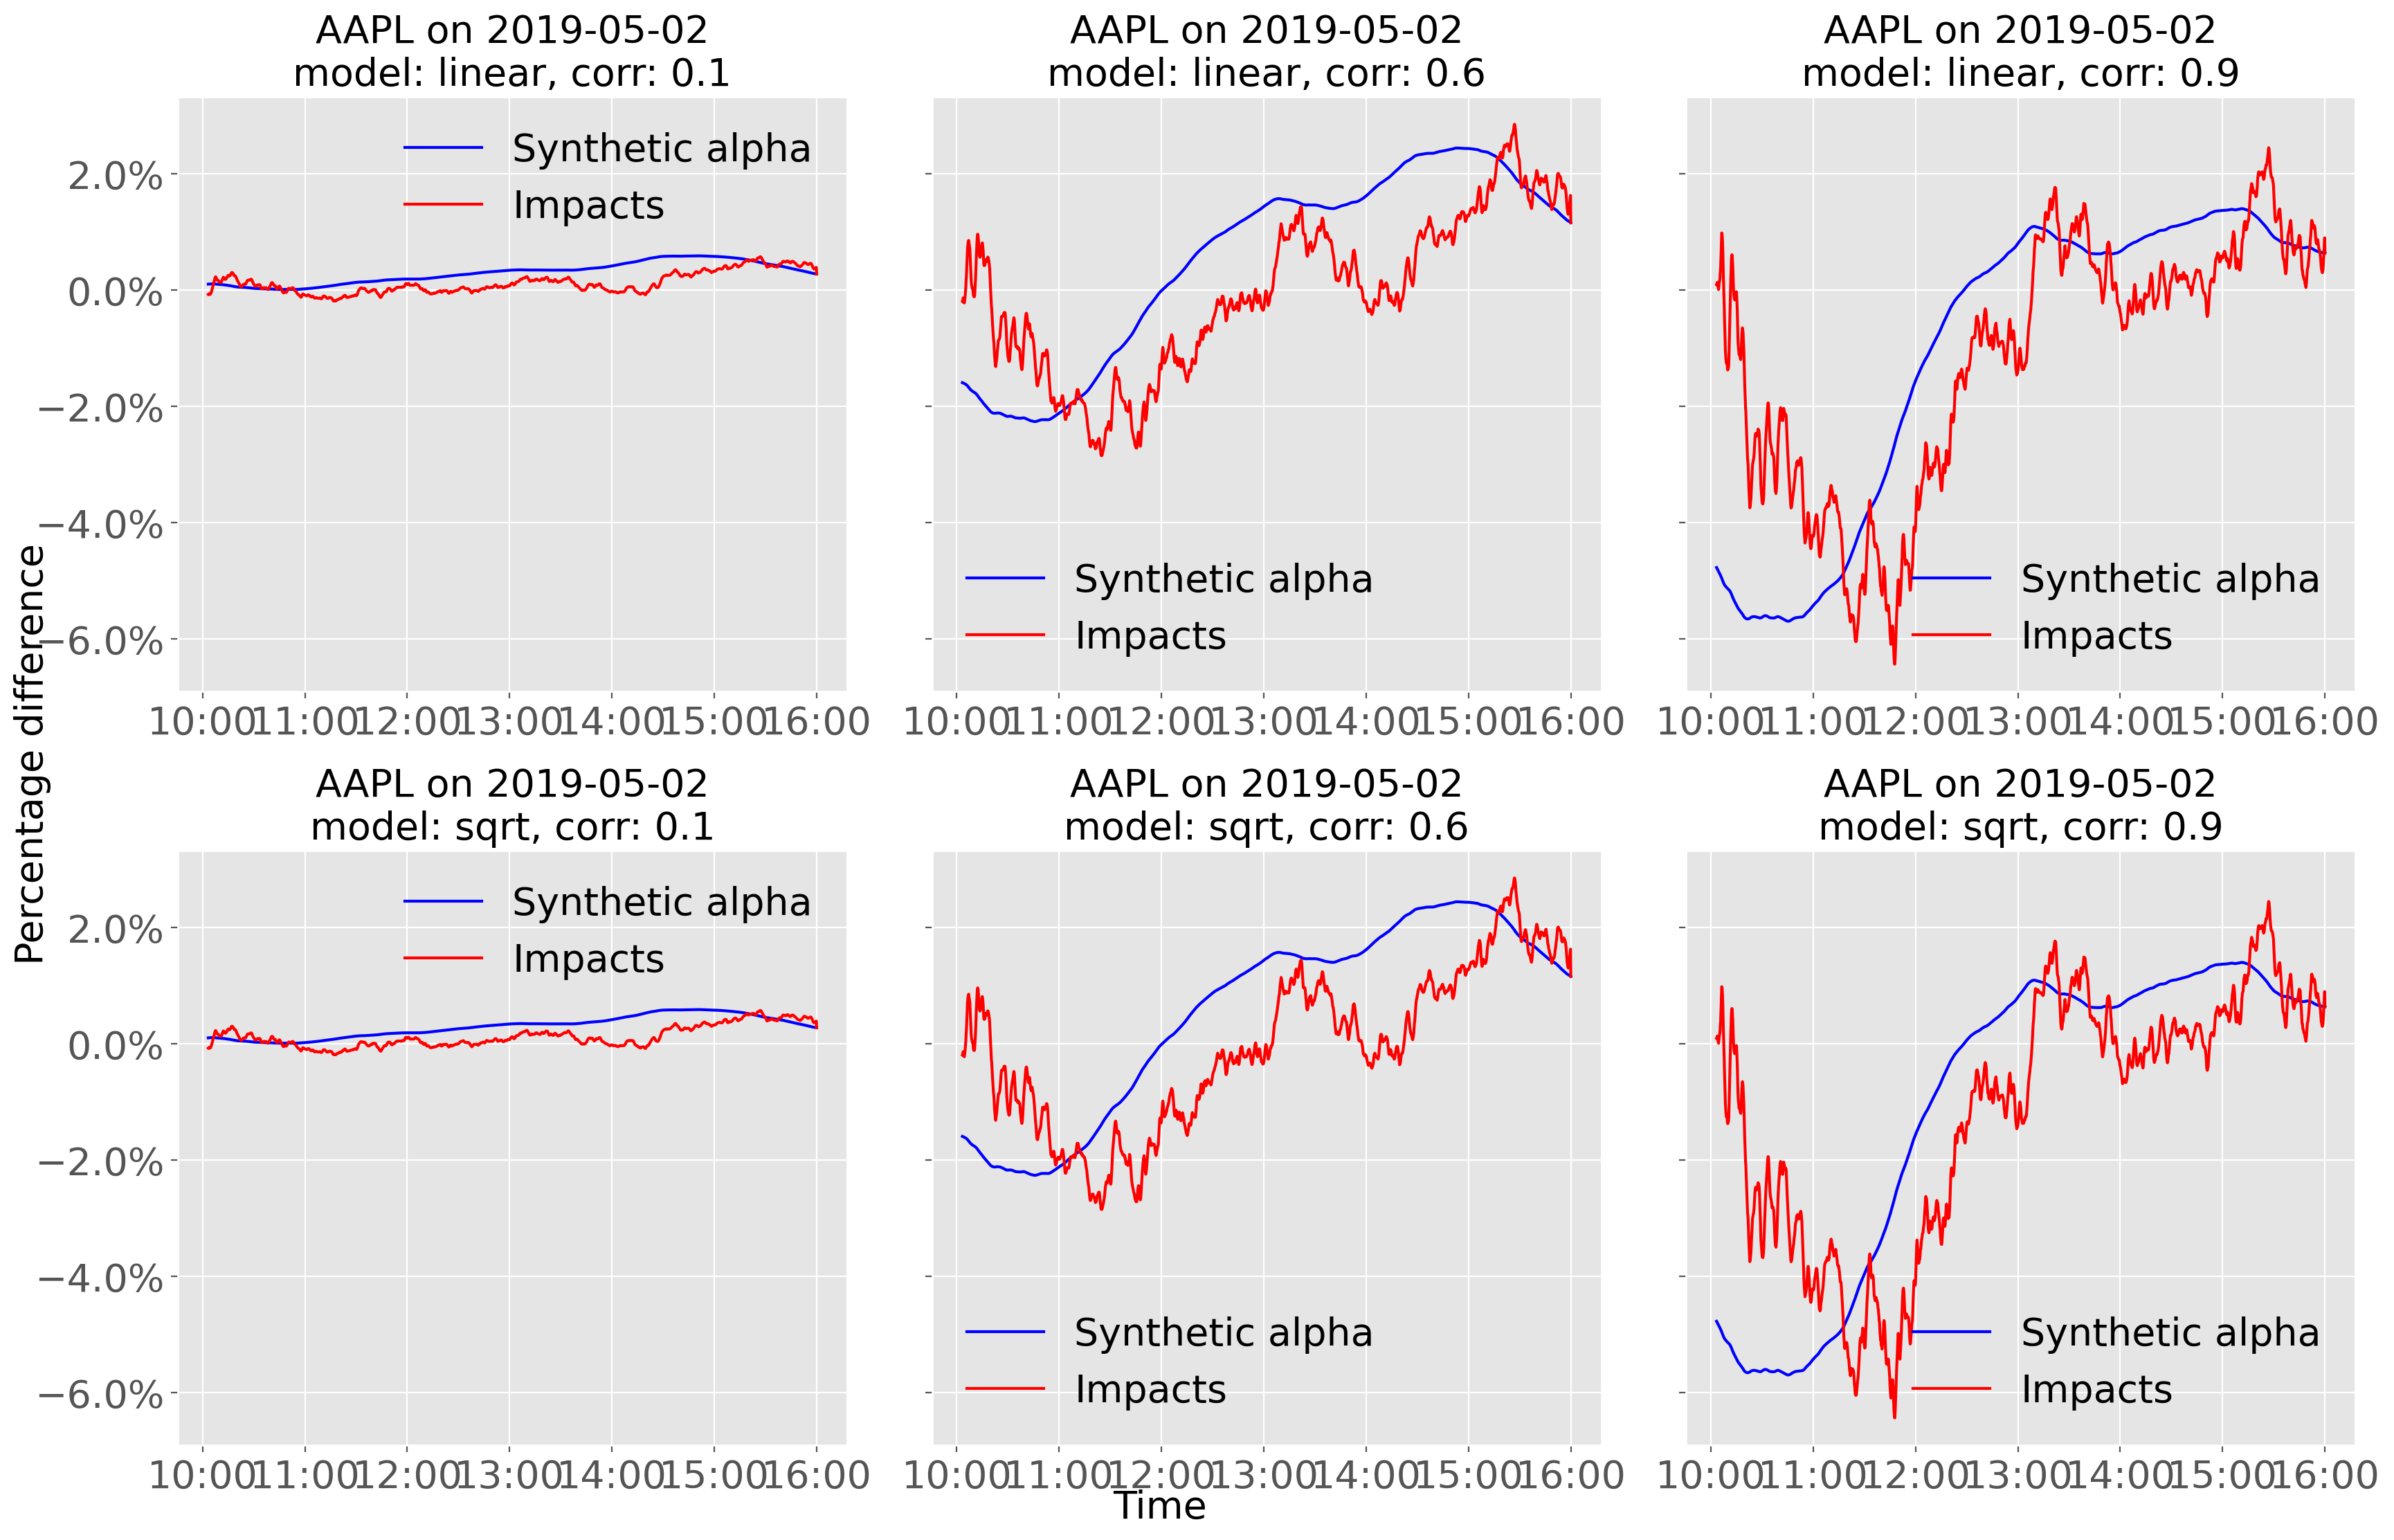

In [9]:
# Plotting of alpha and impact
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for j, model_type in enumerate(model_types):
    for i, corr in enumerate(corrs):
        # Generate synthetic alpha series
        alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

        # Obtain intended impact series
        intended_impacts = 1/2 * (alphas_series - alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
        intended_impacts.iloc[-1] = alphas_series.iloc[-1]

        # Plot the results
        ax = axes[j, i]
        ax.plot(pd.to_datetime(px_df.T.index[200:]), alphas_series.values, label="Synthetic alpha", color='blue')
        ax.plot(pd.to_datetime(px_df.T.index[200:]), intended_impacts.values, label="Impacts", color='red')
        ax.set_title(f"{stock} on {date}\nmodel: {model_type}, corr: {corr}", fontsize=20)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        xfmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(xfmt)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax.legend(fontsize=20, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=20)

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Percentage difference', va='center', rotation='vertical', fontsize=20)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

### Impact of Alpha Horizon (across model)

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/4135075591.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV", color='blue')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/4135075591.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV", color='blue')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/4135075591.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling b

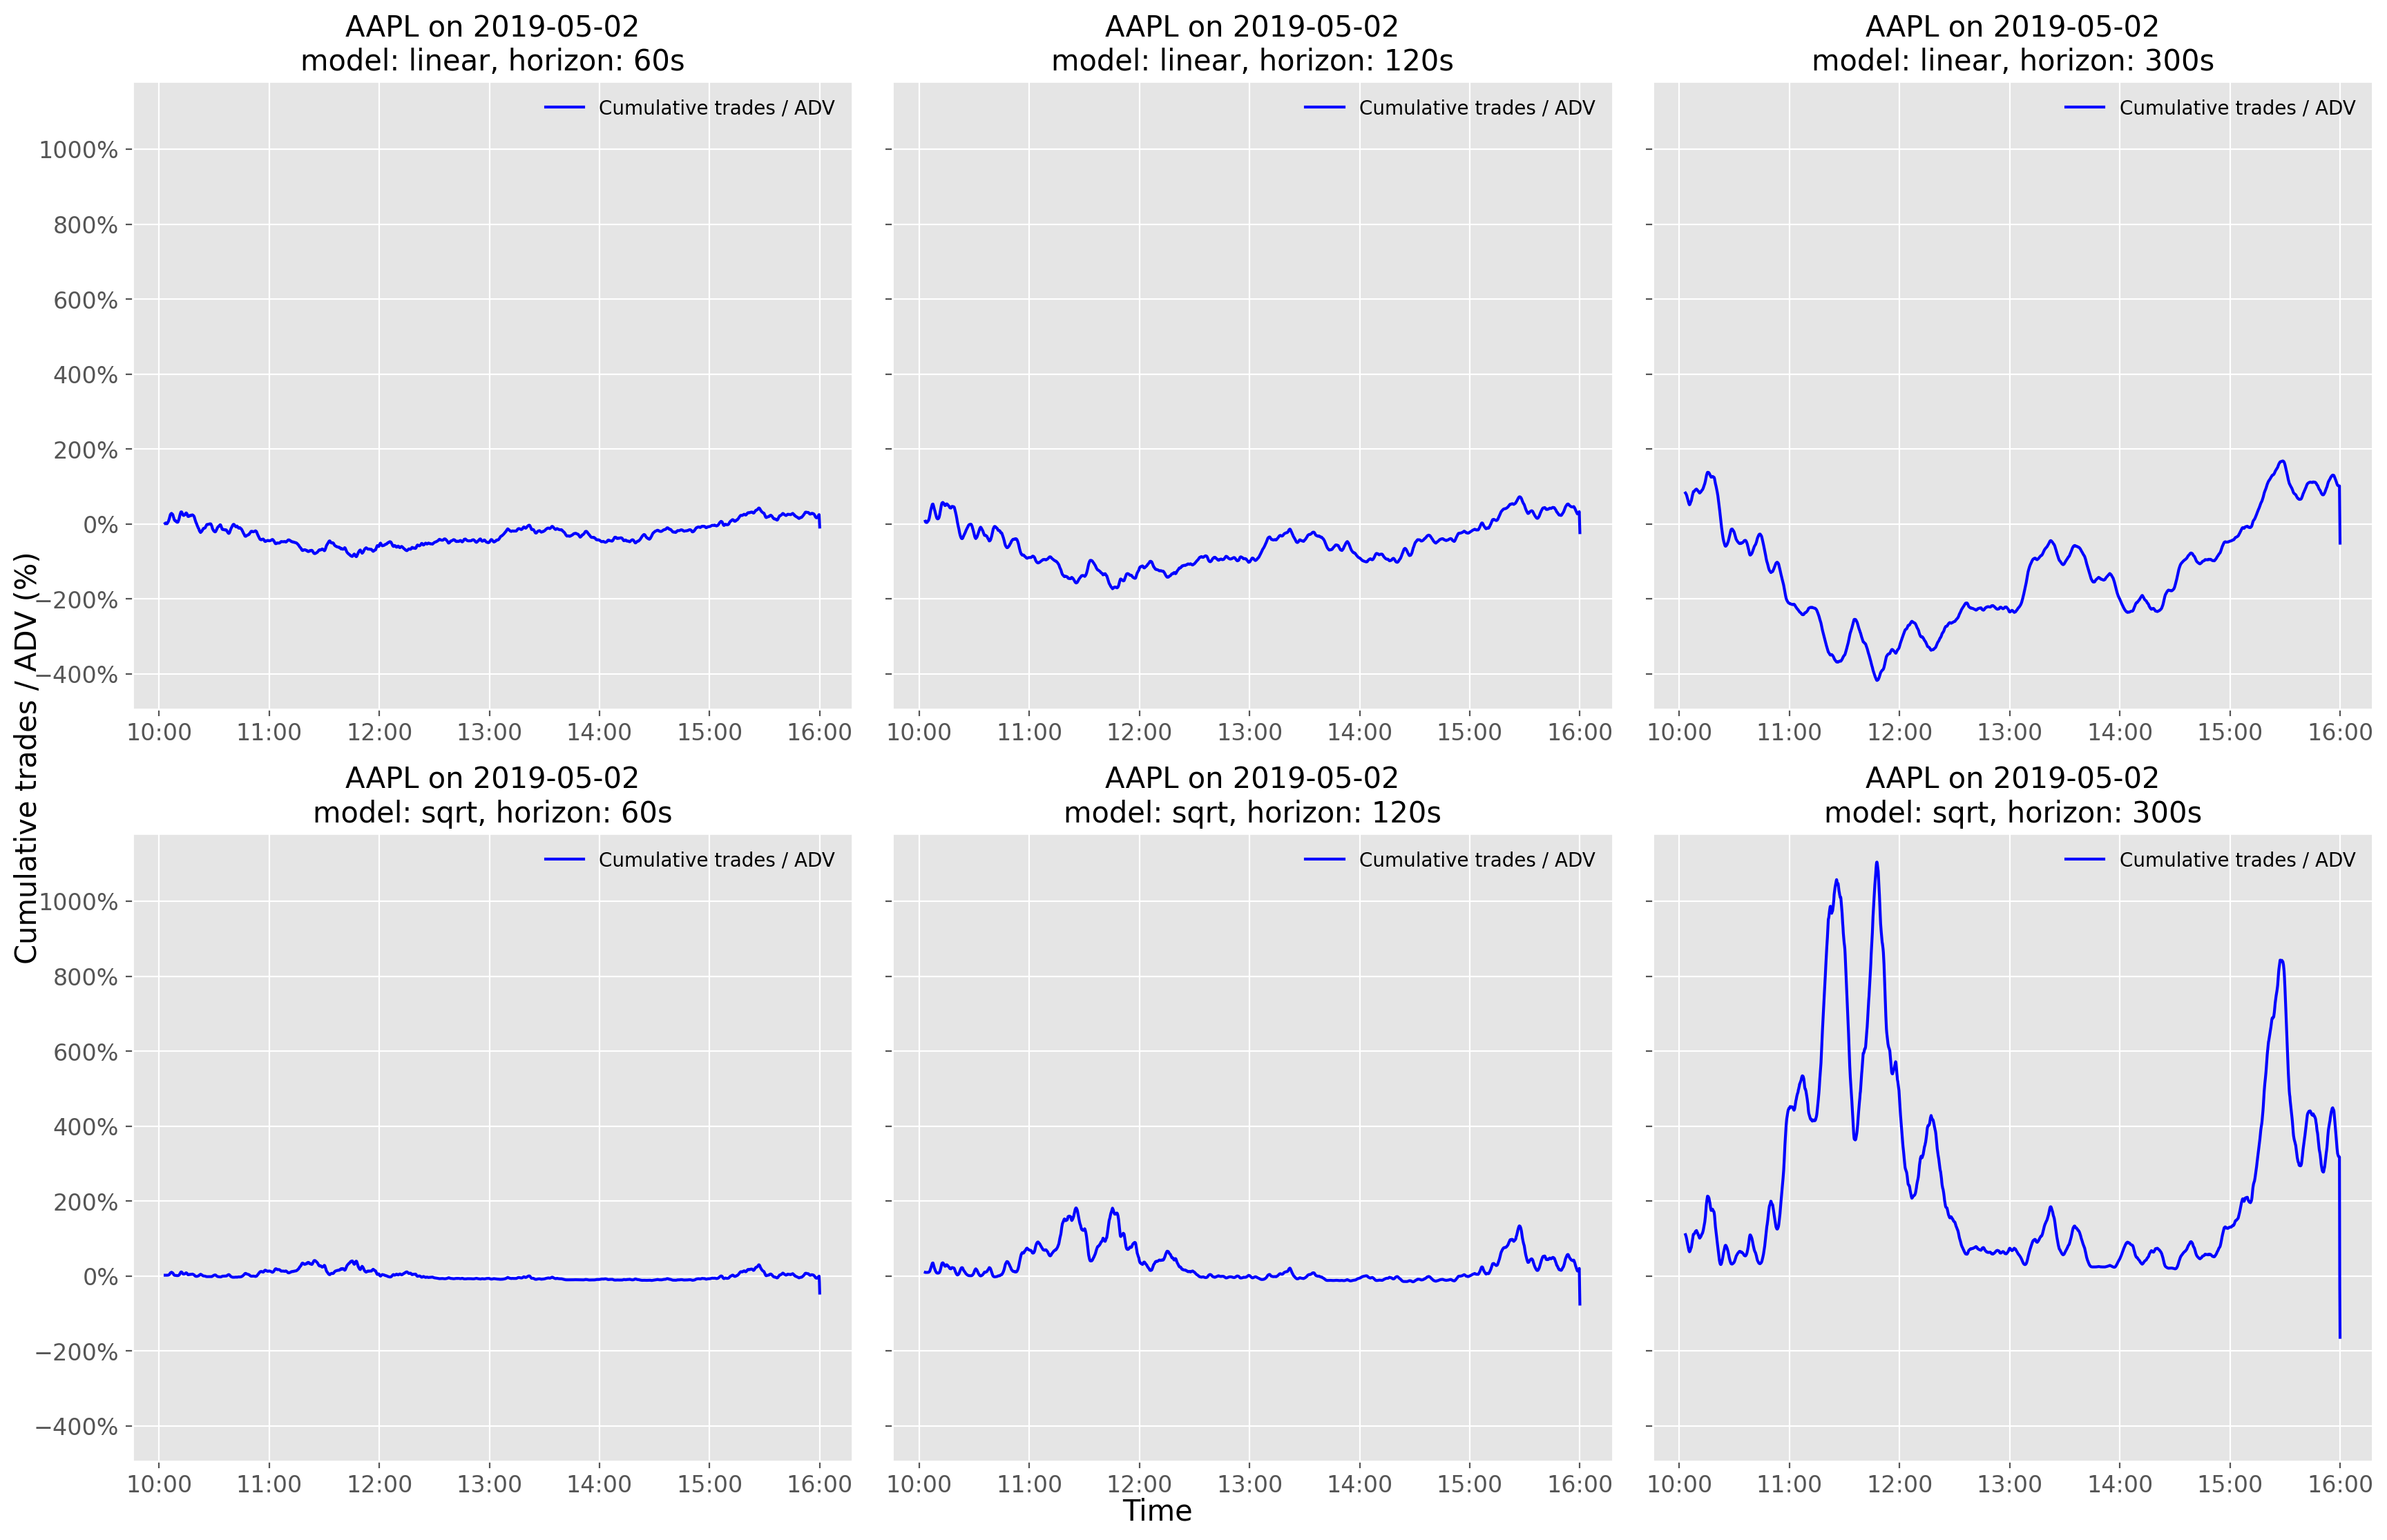

In [10]:
# plot of cumlative trade/adv
corr = 0.6
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for j, model_type in enumerate(model_types):
    for i, alpha_horizon in enumerate(alpha_horizons):
        # Generate synthetic alpha series
        alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

        # Calculate optimal trades
        optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, model_type)
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV

        # Plot the results
        ax = axes[j, i]
        ax.plot(pd.to_datetime(px_df.T.index[200:]), pct_synthetic_alpha_optimal_trades.cumsum().values, label="Cumulative trades / ADV", color='blue')
        ax.set_title(f"{stock} on {date}\nmodel: {model_type}, horizon: {alpha_horizon * time_unit}s", fontsize=15)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        xfmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(xfmt)
        ax.legend(fontsize=10, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=12)

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Cumulative trades / ADV (%)', va='center', rotation='vertical', fontsize=15)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

Model: linear, Correlation: 0.6, Annualized Sharpe: 14.922091987571541, Max Drawdown: -2172943.6911154455


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: linear, Correlation: 0.6, Annualized Sharpe: -18.706180374952233, Max Drawdown: -69101932.14148729


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: linear, Correlation: 0.6, Annualized Sharpe: -28.015927503658887, Max Drawdown: -804497663.0727401


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.6, Annualized Sharpe: -12.990803383401728, Max Drawdown: -25720167.057523496


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.6, Annualized Sharpe: -6.190608055442793, Max Drawdown: -103990699.94082484


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


Model: sqrt, Correlation: 0.6, Annualized Sharpe: 1.0289322257164912, Max Drawdown: -602181345.2902601


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/1091073892.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')


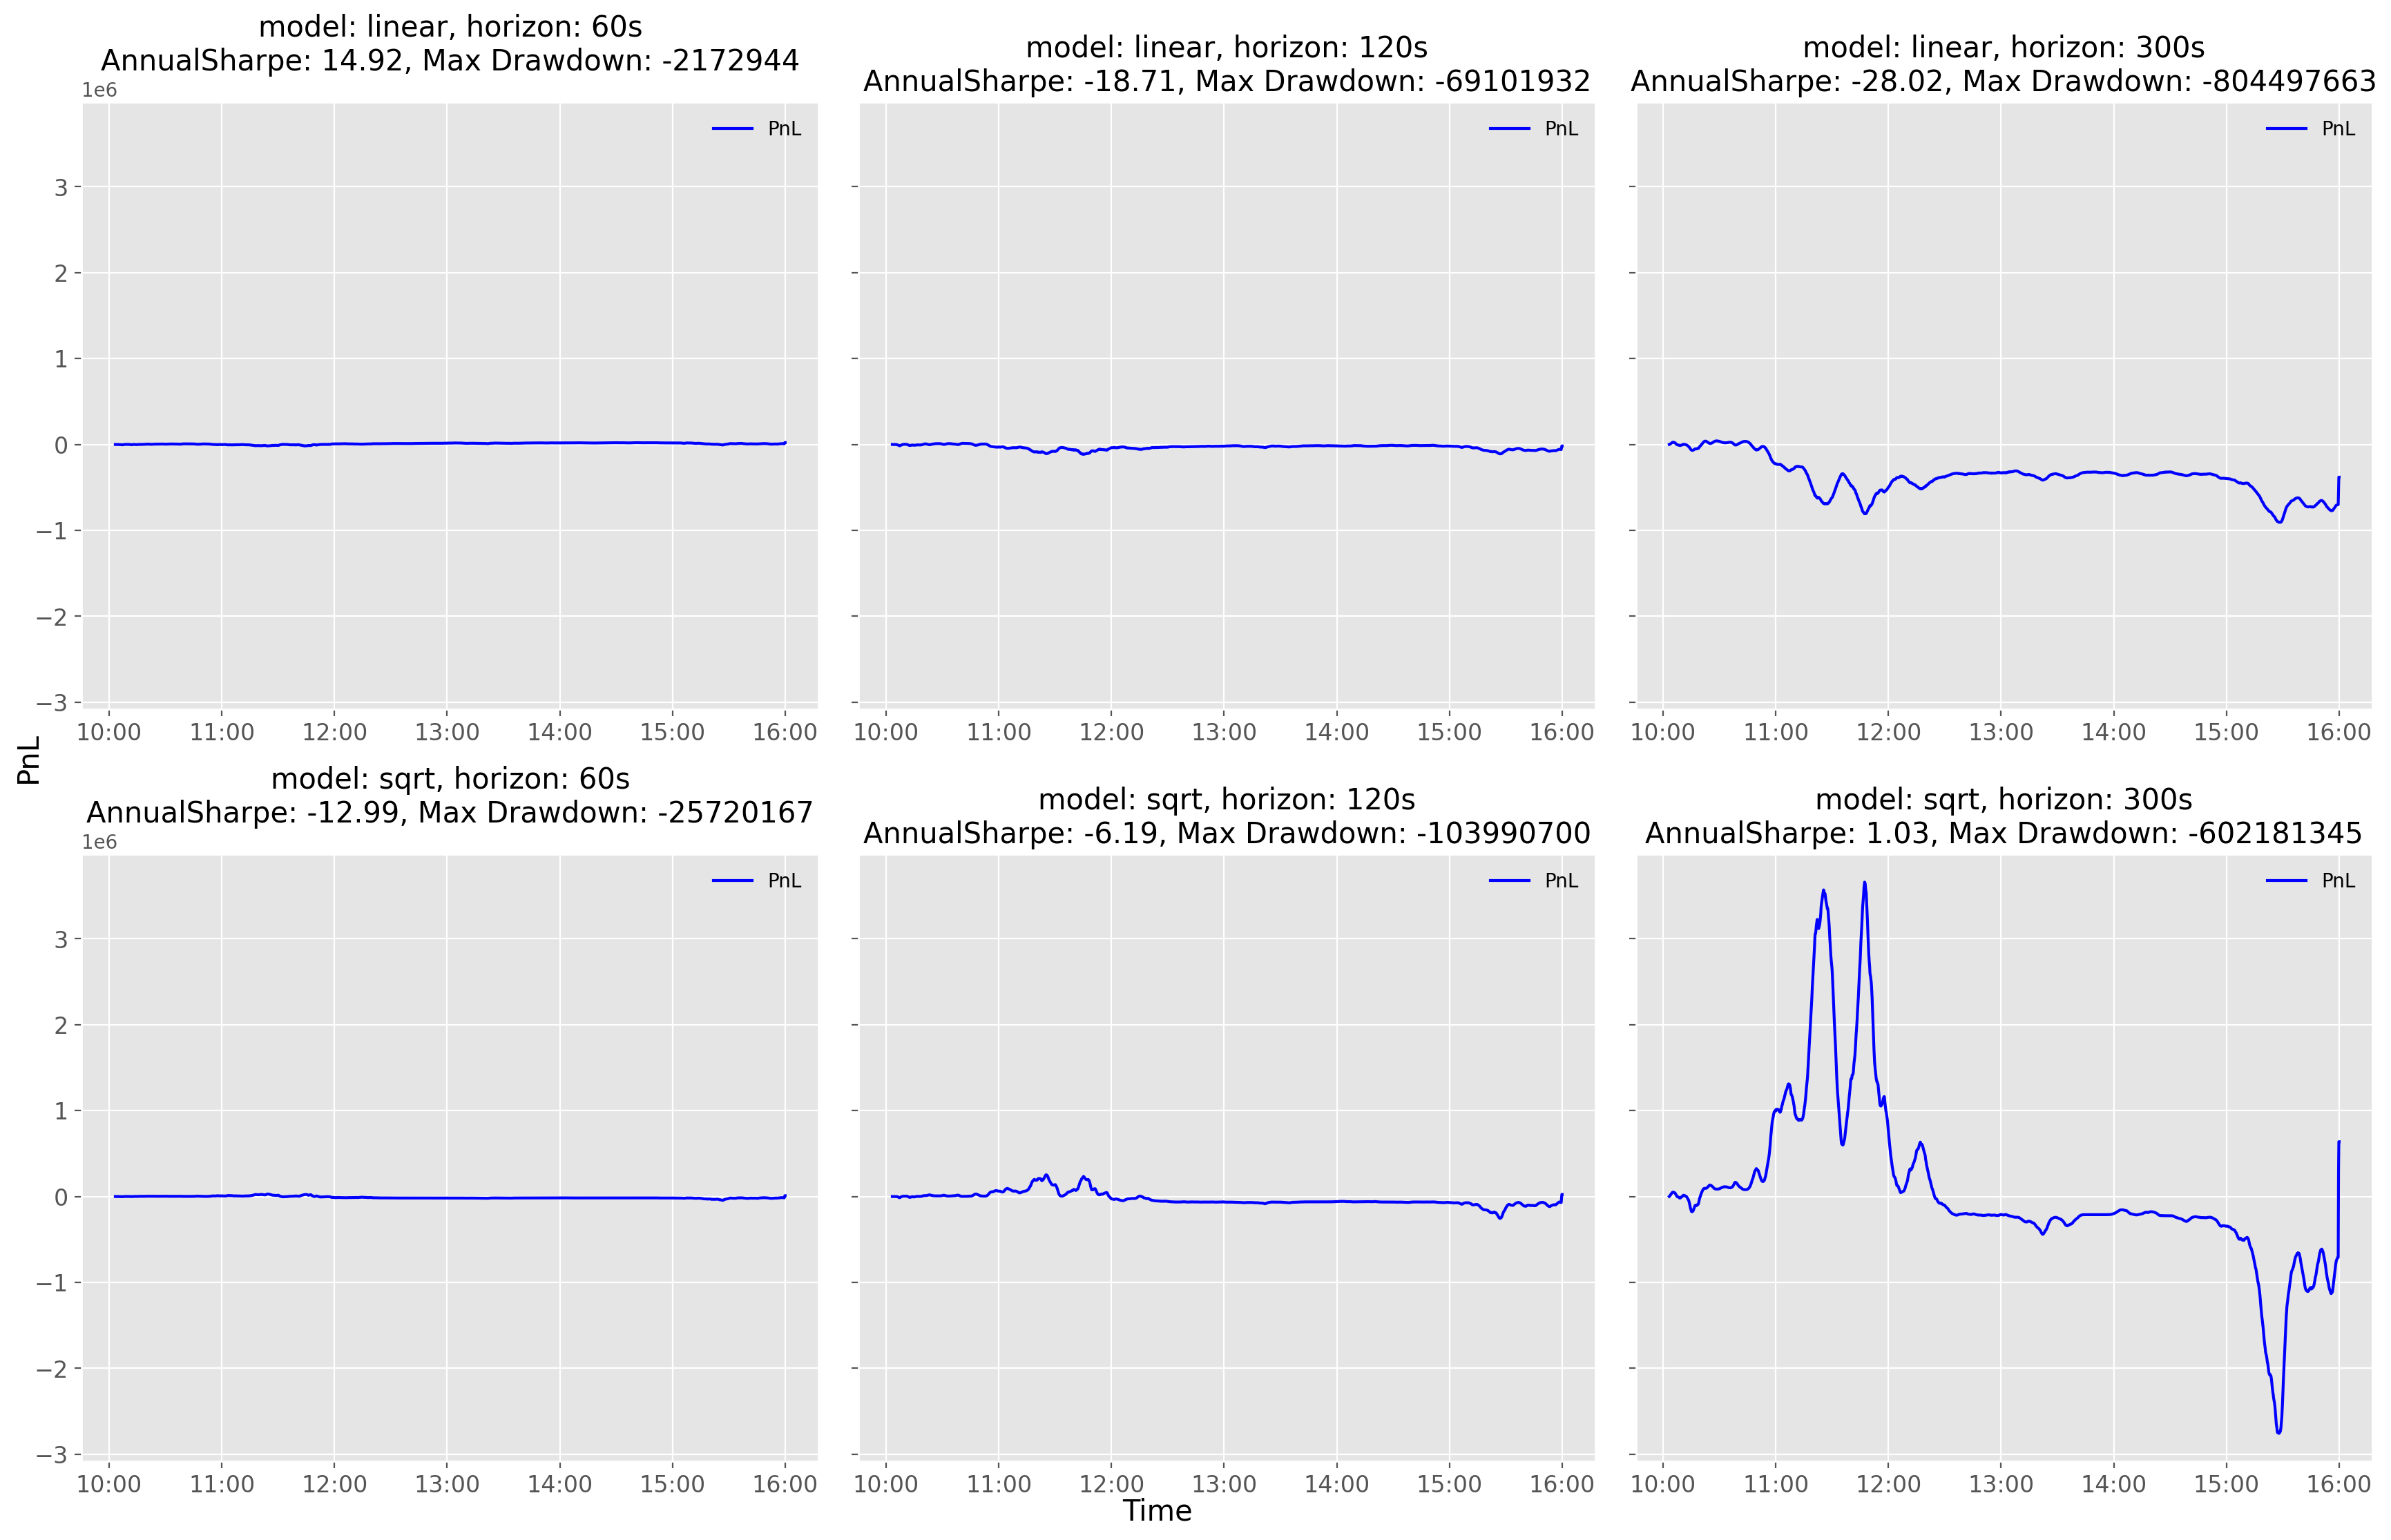

In [11]:
# plot of pnls
# Plotting of pnls
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for j, model_type in enumerate(model_types):
    for i, alpha_horizon in enumerate(alpha_horizons):
        # Generate synthetic alpha series
        alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

        # Calculate optimal trades
        optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, model_type)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV
        
        # Calculate pnl and corresponding metrics
        intended_impacts = BT.get_intended_impact(alphas_series, ow_summary, stock, model_type)
        pnls = backtest(optimal_trades, intended_impacts, prices)
        sharpe, max_drawdown = pnl_metrics(pnls)
        print(f"Model: {model_type}, Correlation: {corr}, Annualized Sharpe: {sharpe}, Max Drawdown: {max_drawdown}")
        
        # Plot the results
        ax = axes[j, i]
        ax.plot(pd.to_datetime(px_df.T.index[200:]), pnls.values.flatten(), label="PnL", color='blue')
        ax.set_title(f"model: {model_type}, horizon: {alpha_horizon * time_unit}s\nAnnualSharpe: {round(sharpe, 2)}, Max Drawdown: {round(max_drawdown)}", fontsize=15)
        xfmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(xfmt)
        ax.legend(fontsize=10, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=12)
        

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'PnL', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2666307375.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), alphas_series.values, label="Synthetic alpha", color='blue')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2666307375.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), intended_impacts.values, label="Impacts", color='red')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2666307375.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify

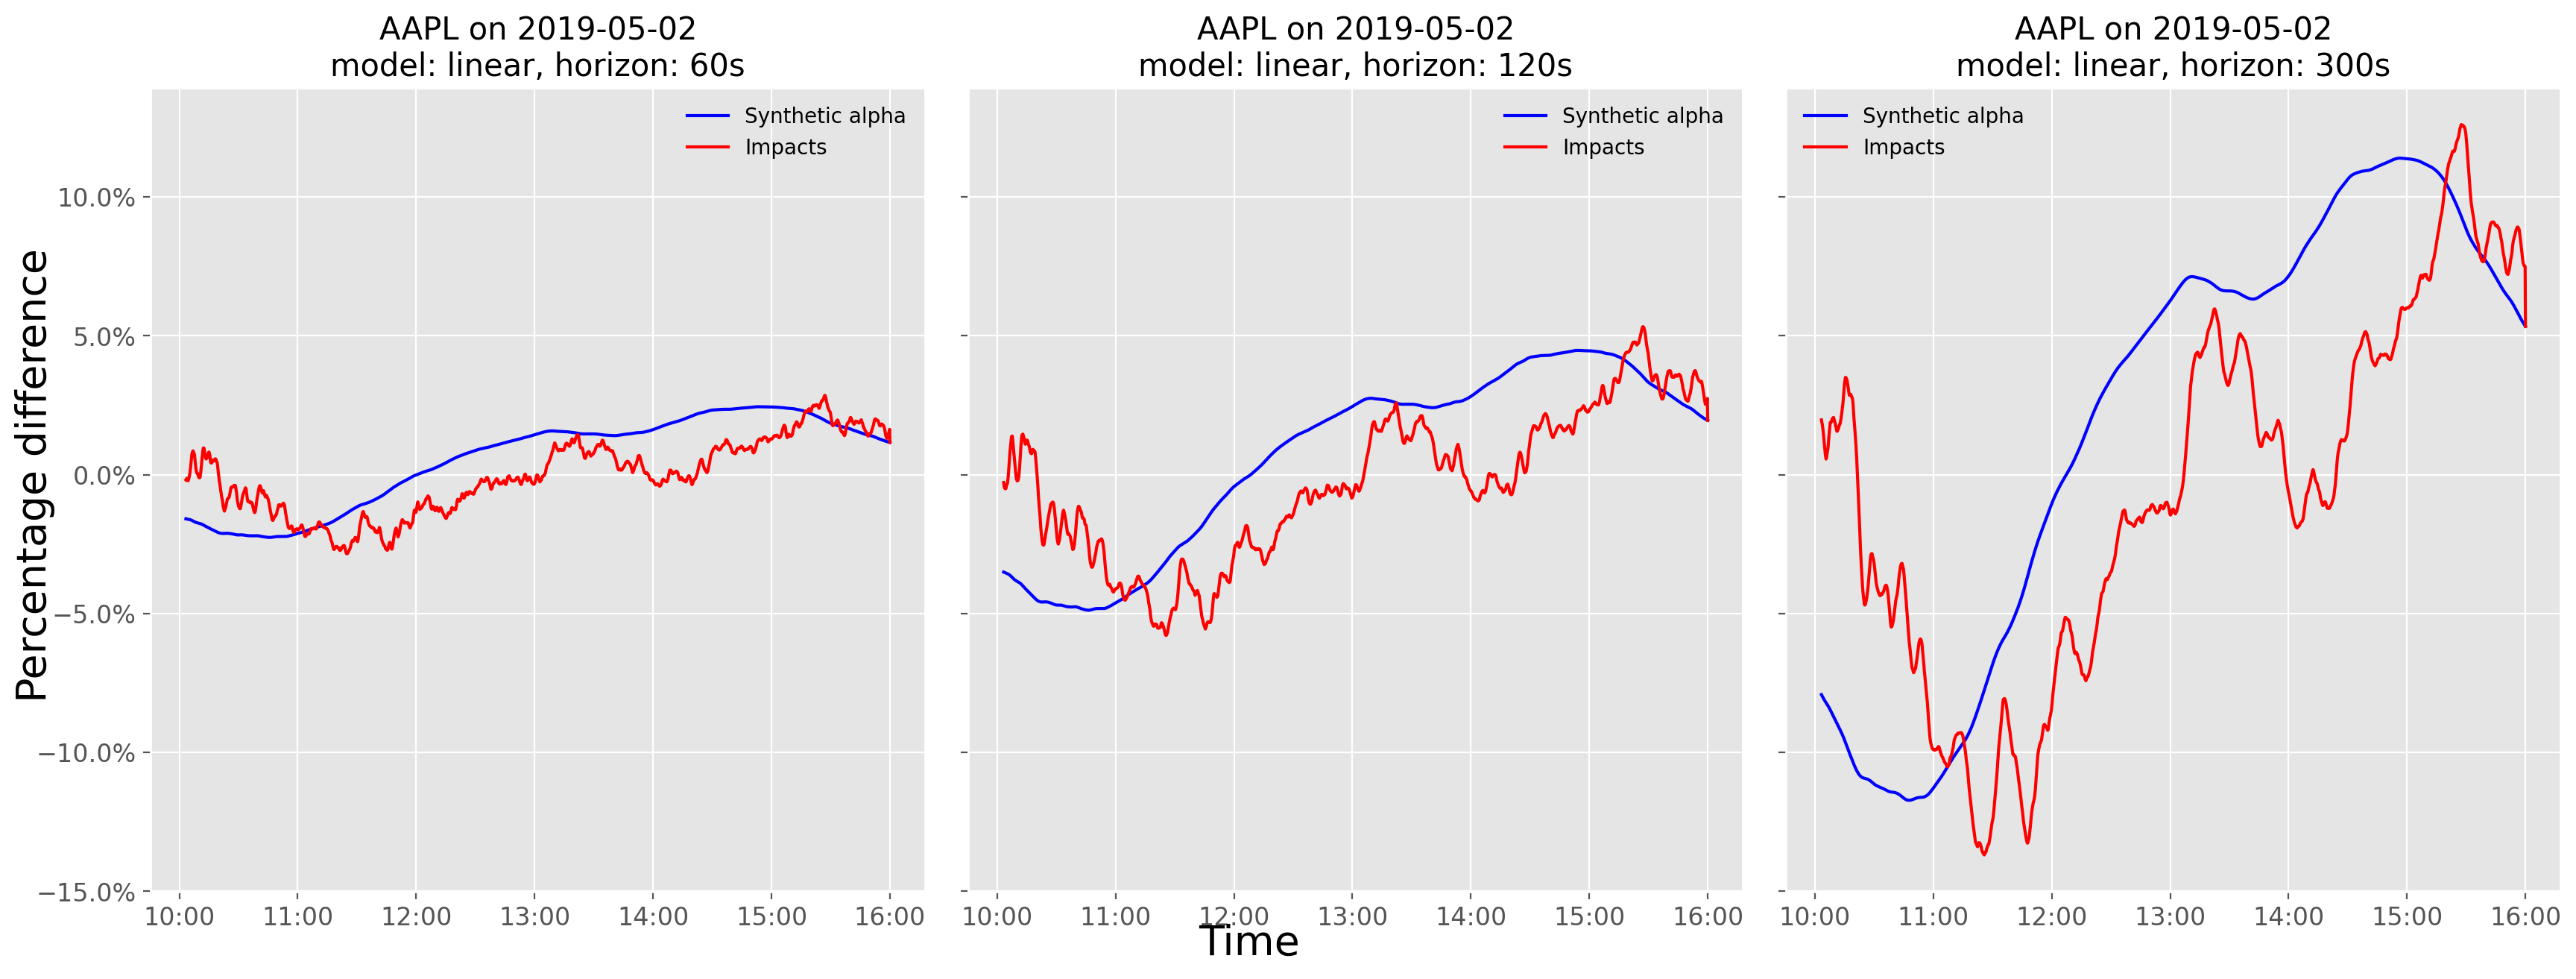

In [12]:
# plot alpha and impacts for linear model
model_type = 'linear'
fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

for i, alpha_horizon in enumerate(alpha_horizons):
    # Generate synthetic alpha series
    alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

    # Obtain intended impact series
    intended_impacts = 1/2 * (alphas_series - alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
    intended_impacts.iloc[-1] = alphas_series.iloc[-1]

    # Plot the results
    ax = axes[i]
    ax.plot(pd.to_datetime(px_df.T.index[200:]), alphas_series.values, label="Synthetic alpha", color='blue')
    ax.plot(pd.to_datetime(px_df.T.index[200:]), intended_impacts.values, label="Impacts", color='red')
    ax.set_title(f"{stock} on {date}\nmodel: {model_type}, horizon: {alpha_horizon * time_unit}s", fontsize=15)
    xfmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.legend(fontsize=10, frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    

# Common X and Y labels
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Percentage difference', va='center', rotation='vertical', fontsize=20)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

### Forced Liquidation

In [13]:
alpha_horizon = 6
# Obtain the synthetic alpha series
alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]
optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, "linear")
pct_synthetic_alpha_optimal_trades = optimal_trades / ADV

# Adjusted prices
px_df2 = impact_adjusted_prices(traded_volume_df.copy(), px_df, monthly_scaling_factor, half_life, ow_summary, "linear")
prices = px_df2.loc[(px_df2["stock"] == stock) & (px_df2["date"] == date)].iloc[:, 202:]

# create optimal alpha and impact
alphas_series_liquidation = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]

# Generate intended impacts for forced liquidation scenario
intended_impacts_liquidation = 1 / 2 * (alphas_series_liquidation - alphas_series_liquidation.diff(1).shift(-1).fillna(0) / beta / time_unit)
intended_impacts_liquidation.iloc[-1] = alphas_series_liquidation.iloc[-1]
# Generate optimal trades
optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series_liquidation, ow_summary, stock, date, "linear")
# impact resultant price
impact_resultant_px_original = impact_resultant_prices(optimal_trades, prices.values[0], decay_factor, ow_summary.loc[stock, "beta_estimate"], linear_kernel, px_vol, ADV)
# Simulate forced liquidation
forced_liquidation_index = len(alphas_series_liquidation) // 2
liquidation_volume = np.sum(optimal_trades[:forced_liquidation_index])
forced_trades = optimal_trades.copy()
forced_trades[forced_liquidation_index] = - liquidation_volume
forced_trades[forced_liquidation_index+1:] = 0  # create the trades where one liquidate halfway
# Generate the impact resultant prices after forced liquidation
impact_resultant_px_liquidation = impact_resultant_prices(forced_trades, prices.values[0], decay_factor, ow_summary.loc[stock, "beta_estimate"], linear_kernel, px_vol, ADV)


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2876287762.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), prices, label="Fundamental Prices", color='blue', linewidth=2)
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2876287762.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df.T.index[200:]), impact_resultant_px_original, label="Impact Resultant Prices", color='green', linewidth=2, alpha=0.7, linestyle='-.')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_75183/2876287762.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. T

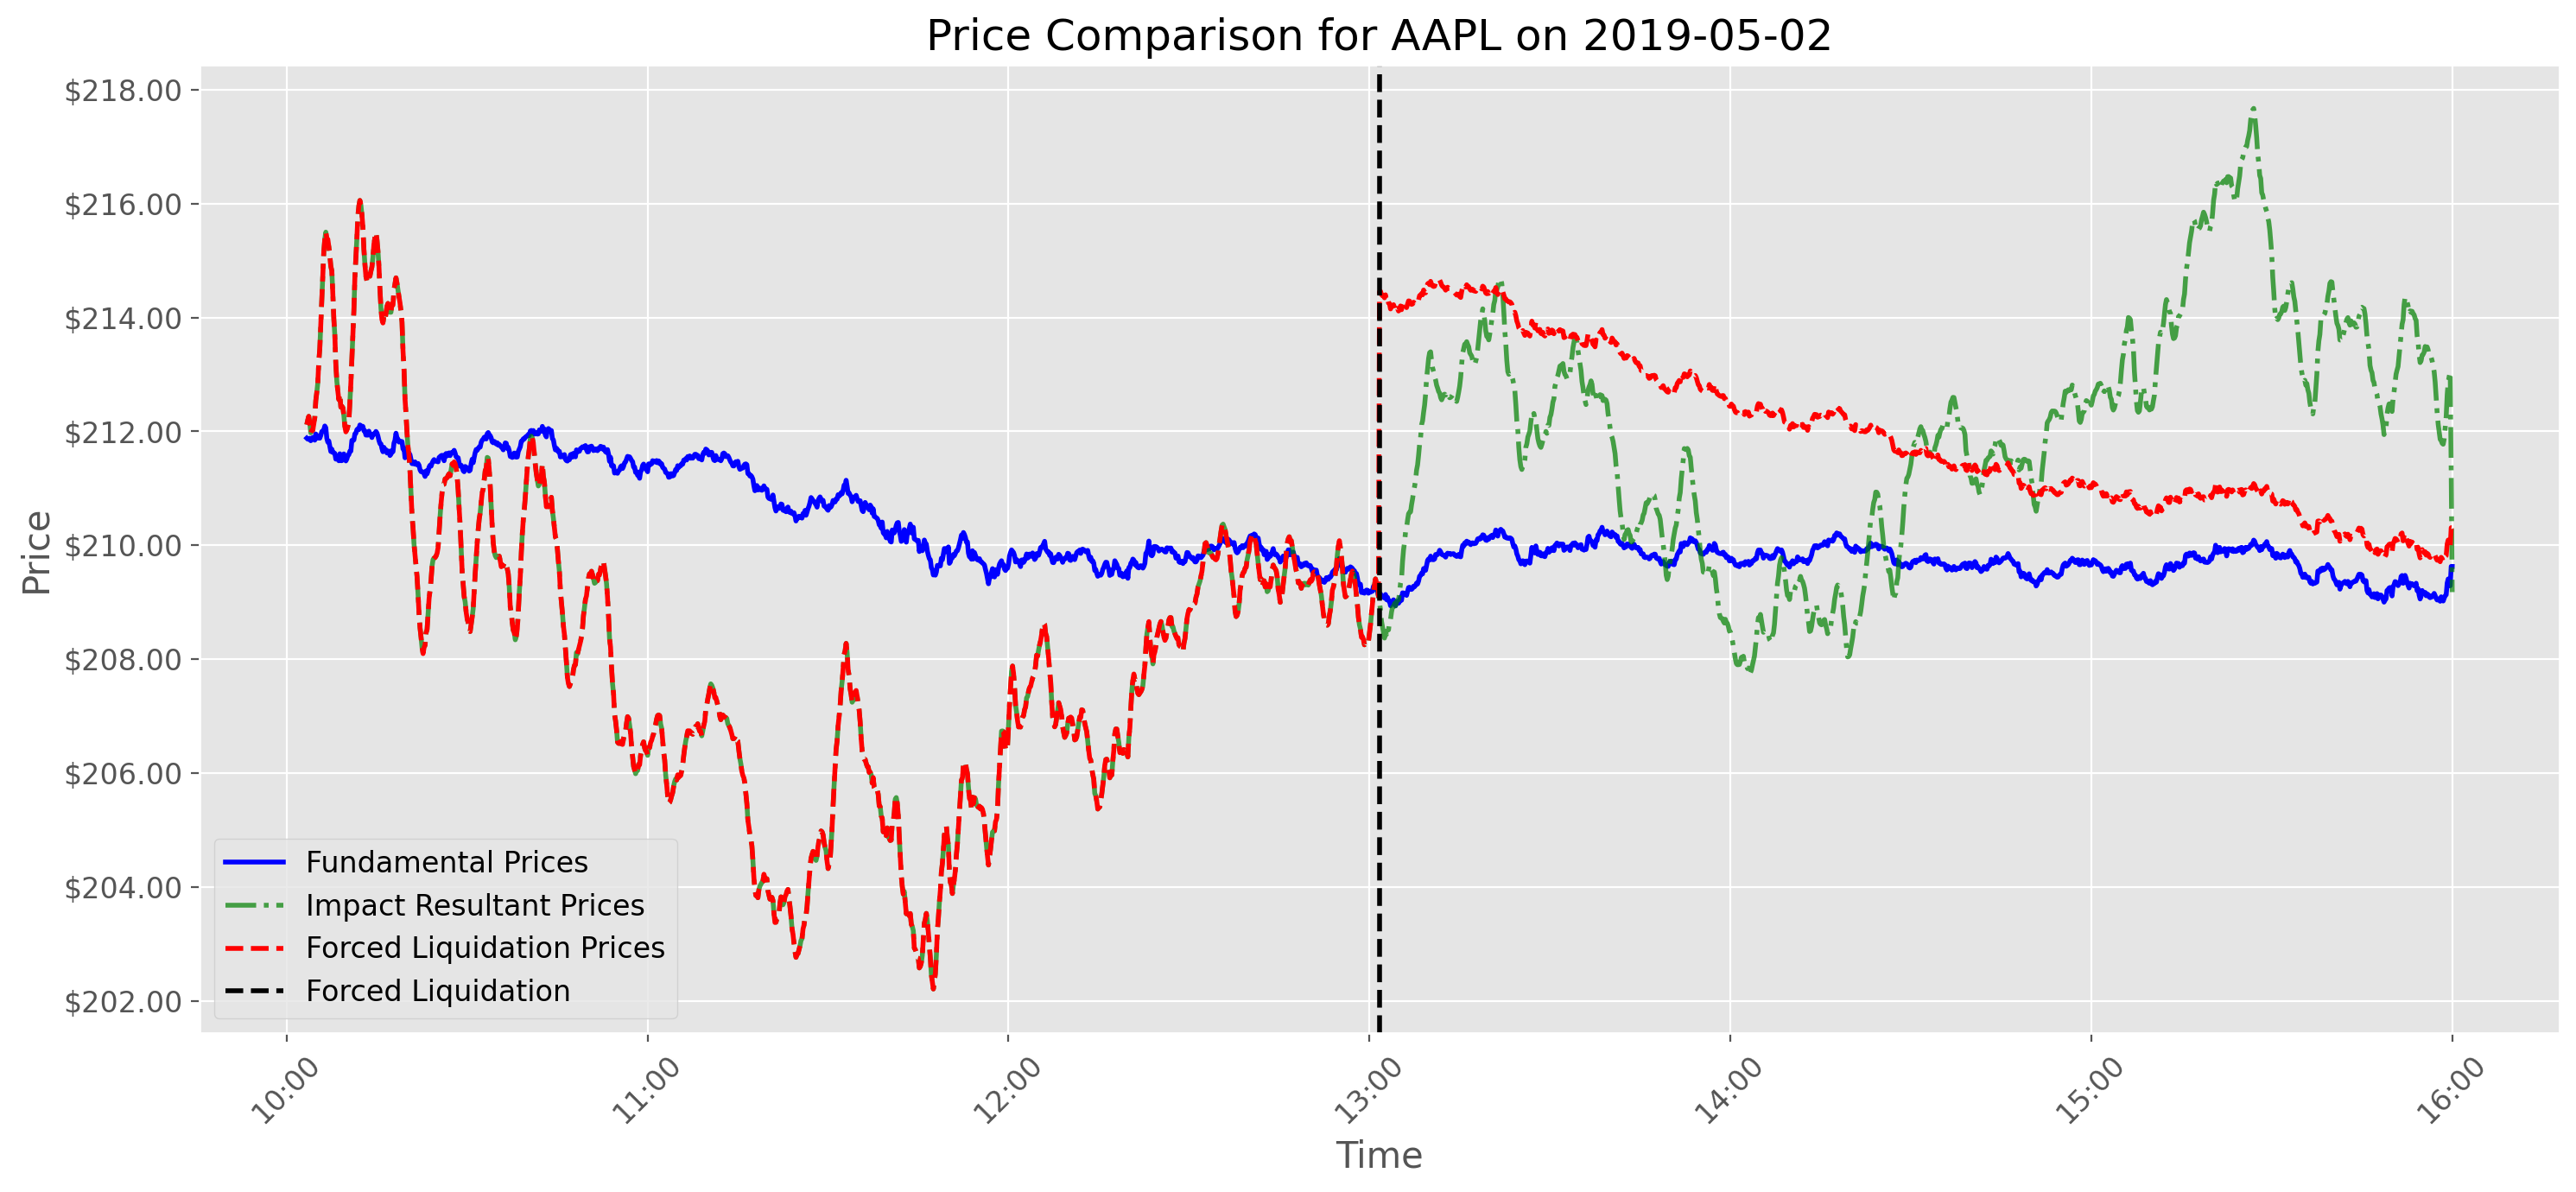

In [14]:
# Plot the three prices
def plot_price_results(prices, impact_resultant_px_original, impact_resultant_px_liquidation, forced_liquidation_index):
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(pd.to_datetime(px_df.T.index[200:]), prices, label="Fundamental Prices", color='blue', linewidth=2)
    ax.plot(pd.to_datetime(px_df.T.index[200:]), impact_resultant_px_original, label="Impact Resultant Prices", color='green', linewidth=2, alpha=0.7, linestyle='-.')
    ax.plot(pd.to_datetime(px_df.T.index[200:]), impact_resultant_px_liquidation, label="Forced Liquidation Prices", color='red', linewidth=2, alpha=1, linestyle='--')
    ax.axvline(pd.to_datetime(px_df.T.index[200:][forced_liquidation_index]), color='black', linestyle='--', linewidth=2, label='Forced Liquidation')

    ax.set_title(f"Price Comparison for {stock} on {date}", fontsize=18)
    ax.set_xlabel('Time', fontsize=15)
    ax.set_ylabel('Price', fontsize=15)
    ax.legend(fontsize=12)
    ax.grid(True)

    xfmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# Call the plotting function
plot_price_results(prices.values[0], impact_resultant_px_original, impact_resultant_px_liquidation, forced_liquidation_index)

#### PNL under liquidation, need revisit